<a href="https://colab.research.google.com/github/SBanditaDas/American-Sign-Language-Real-Time-Prediction/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploading my Kaggle API Token

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dasbanditasushree","key":"2c14987132f86933aec1f5d96e2e974c"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the ASL Dataset

In [3]:
!kaggle datasets download -d asthalochanmohanta/american-sign-language-asl

Dataset URL: https://www.kaggle.com/datasets/asthalochanmohanta/american-sign-language-asl
License(s): apache-2.0
 99% 3.09G/3.11G [00:36<00:00, 80.7MB/s]
100% 3.11G/3.11G [00:37<00:00, 90.1MB/s]


Unzipping the Dataset

In [4]:
!unzip american-sign-language-asl.zip -d /content/ASL_detection/

Archive:  american-sign-language-asl.zip
  inflating: /content/ASL_detection/dataset_v2/test/again/again_asl_video_2023-12-12_12-32-39.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/again/again_asl_video_2023-12-12_12-34-48.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/again/again_asl_video_2023-12-12_12-34-59.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/again/again_asl_video_2023-12-12_12-37-29.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/again/again_asl_video_2023-12-12_12-38-50.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/again/again_asl_video_2023-12-12_12-39-40.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/again/again_asl_video_2023-12-12_12-39-54.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/again/again_asl_video_2023-12-12_12-40-25.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/bad/bad_asl_video_2023-12-10_13-59-19.mp4  
  inflating: /content/ASL_detection/dataset_v2/test/bad/bad_asl

 Folder Structure

In [5]:
import os

for root, dirs, files in os.walk("/content/ASL_detection"):
    print("📁", root)
    for d in dirs:
        print("   └──", d)

📁 /content/ASL_detection
   └── dataset_v2
📁 /content/ASL_detection/dataset_v2
   └── test
   └── val
   └── train
📁 /content/ASL_detection/dataset_v2/test
   └── mother
   └── milk
   └── same
   └── book
   └── you
   └── thank you
   └── sad
   └── wrong
   └── more
   └── do not want
   └── fine
   └── i
   └── what
   └── want
   └── again
   └── eat
   └── need
   └── please
   └── question
   └── yes
   └── hello
   └── bad
   └── help
   └── go
   └── why
   └── finish
   └── no
   └── which
   └── forget
   └── your
   └── bathroom
   └── meet
   └── where
   └── how
   └── good
   └── my
   └── nice
   └── like
   └── father
   └── busy
   └── name
   └── learn
   └── right
   └── see you letter
   └── when
   └── happy
   └── who
📁 /content/ASL_detection/dataset_v2/test/mother
📁 /content/ASL_detection/dataset_v2/test/milk
📁 /content/ASL_detection/dataset_v2/test/same
📁 /content/ASL_detection/dataset_v2/test/book
📁 /content/ASL_detection/dataset_v2/test/you
📁 /content/ASL_det

Installing the required liabraries

In [6]:
!pip install tensorflow opencv-python matplotlib seaborn

Extracting Frames from Videos

In [10]:
import cv2
import os

video_root = '/content/ASL_detection/dataset_v2/test'
output_root = '/content/ASL_detection/frames/test'

os.makedirs(output_root, exist_ok=True)

for class_name in os.listdir(video_root):
    class_path = os.path.join(video_root, class_name)
    if os.path.isdir(class_path):
        output_class_path = os.path.join(output_root, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for video_file in os.listdir(class_path):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(class_path, video_file)
                cap = cv2.VideoCapture(video_path)
                frame_count = 0
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    if frame_count % 10 == 0:
                        frame_name = f"{video_file[:-4]}_frame{frame_count}.jpg"
                        cv2.imwrite(os.path.join(output_class_path, frame_name), frame)
                    frame_count += 1
                cap.release()

Setting Image Dataset Paths

In [11]:
train_path = '/content/ASL_detection/frames/train'
test_path = '/content/ASL_detection/frames/test'

Loading & Preprocessing the data

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

Found 17369 images belonging to 47 classes.
Found 2040 images belonging to 47 classes.


 Building and Training the CNN Model

Defining the model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train:

In [15]:
history = model.fit(
    train_data,
    epochs=3,  # You can increase this later
    validation_data=test_data
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 166s 151ms/step - accuracy: 0.4176 - loss: 2.0947 - val_accuracy: 0.9225 - val_loss: 0.2484
Epoch 2/3
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 164s 151ms/step - accuracy: 0.8417 - loss: 0.4641 - val_accuracy: 0.9686 - val_loss: 0.1119
Epoch 3/3
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 157s 145ms/step - accuracy: 0.8998 - loss: 0.3004 - val_accuracy: 0.9740 - val_loss: 0.0840


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the Model to Google Drive



In [17]:
model.save('/content/drive/MyDrive/ASL_detection/asl_model.h5')
print("Model saved successfully!")

Model saved successfully!


Visualizing the Accuracy and the Loss

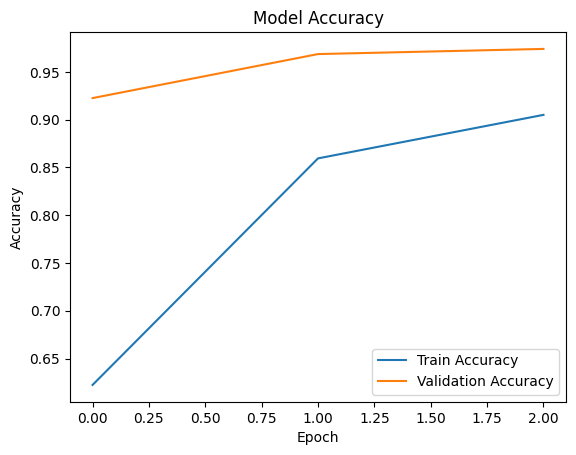

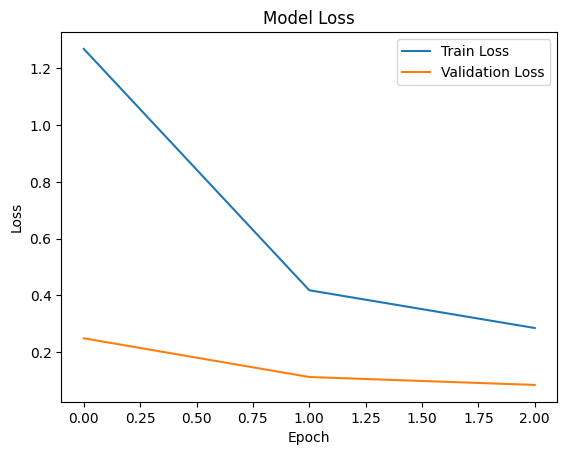

In [18]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Exporting Class Labels (for Prediction or Deployment)

In [19]:
labels = list(train_data.class_indices.keys())

with open('/content/drive/MyDrive/ASL_detection/labels.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

print("labels.txt saved successfully!")

labels.txt saved successfully!


Predict from Uploaded Image

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Loading the model
model = load_model('/content/drive/MyDrive/ASL_detection/asl_model.h5')

# Uploading an image
uploaded = files.upload()

# Predict :
for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(64, 64))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    with open('/content/drive/MyDrive/ASL_detection/labels.txt') as f:
        labels = f.read().splitlines()

    print("Predicted Sign:", labels[predicted_class])

In [23]:
model = load_model('/content/drive/MyDrive/ASL_detection/asl_model.h5')

In [24]:
with open('/content/drive/MyDrive/ASL_detection/labels.txt') as f:
    labels = f.read().splitlines()

Real-Time Webcam Prediction

Saving hand1_l_bot_seg_1_cropped.jpeg to hand1_l_bot_seg_1_cropped.jpeg


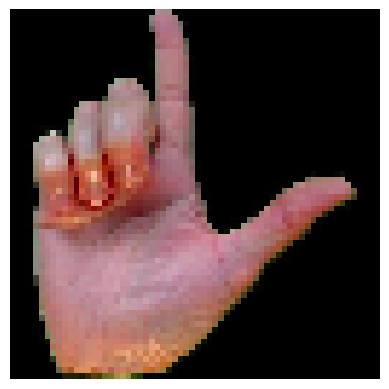

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted Sign: forget


In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Load model and labels from Drive
model = load_model('/content/drive/MyDrive/ASL_detection/asl_model.h5')

with open('/content/drive/MyDrive/ASL_detection/labels.txt') as f:
    labels = f.read().splitlines()

# Upload image
uploaded = files.upload()

# Predict
for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(64, 64))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    print("Predicted Sign:", labels[predicted_class])